In [1]:
import glicko2 as Glicko

In [2]:
# improbable results are likely so set tau low
TAU = 0.2     # system constant
MU = 1500
PHI = 500     # Starting rating deviation
SIGMA = 0.03  # starting volatility

In [3]:
glck = Glicko.Glicko2(mu=MU, tau=TAU, phi=PHI, sigma=SIGMA)

In [4]:
import pandas as pd
import math
import numpy as np

In [5]:
import seaborn as sns

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
naf_data = pd.read_csv("data/all_matches.csv.gz", sep=",",
                       index_col=None)

In [8]:
naf_data["date"] = pd.to_datetime(
    naf_data.date, format="%Y/%m/%d")

In [9]:
naf_data.set_index("date", inplace=True)

In [10]:
naf_data.sort_index(inplace=True)

In [11]:
# up to June '17 due to errors in data
naf_data = naf_data[:pd.Timestamp('2017-06-01')]

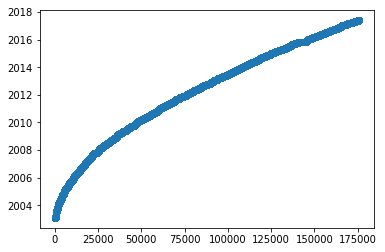

In [12]:
plt.plot(naf_data.index, "o")

## Set lookup

In [13]:
race_ids = sorted(naf_data.home_race.unique())

In [14]:
class Player(object):
    
    # need to maintain only historical rankings, not phi etc.
    hist_mu = None
    hist_phi = None
    
    def __init__(self, player_id, periods):
        
        self.pid = player_id
        self.hist_mu = pd.DataFrame(
            columns=race_ids, index=periods, dtype=float)
        self.hist_phi = pd.DataFrame(
            columns=race_ids, index=periods, dtype=float)
        self.rankings = {}
        self.new_rankings = {}
              
    def init_rating(self, race_id, method="median"):
        
        if (method == "default") or (len(self.rankings) < 2):
            
            self.rankings[race_id] = glck.create_rating(
                mu=MU, phi=PHI, sigma=SIGMA)
            
        elif method == "median":
            # other rankings. Possibly exclude stunties? 
            # divide PHI by the number of other ranks?
            # Or always start stunties at 1500?
            mu_vals = [v.mu for v in self.rankings.values()]
            phi_vals = [v.phi for v in self.rankings.values()]
            _mu = np.median(mu_vals)
            _phi = np.max(phi_vals)

            self.rankings[race_id] = glck.create_rating(
                mu=_mu, phi=_phi, sigma=SIGMA)

        return self.rankings[race_id]
    
    def end_ranking_period(self, date):
        
        # copy new rankings
        for race in self.hist_mu.columns:
            if (race in self.rankings) and (race not in self.new_rankings):
                self.rankings[race] = self.decay(race)
            elif race in self.new_rankings:
                self.rankings[race] = self.new_rankings[race]
                
        # delete temp ranks
        self.new_rankings = {}
        
        # fill historical with rankings.
        for rid, rank in self.rankings.items():
            self.hist_mu[rid].loc[date] = rank.mu
            self.hist_phi[rid].loc[date] = rank.phi
            
    def decay(self, race):
        
        # transform into glicko space...
        dnp = glck.scale_down(self.rankings[race])
        
        # increment phi
        phi_star = math.sqrt(min(PHI, dnp.phi ** 2 + dnp.sigma ** 2))
                
        return glck.scale_up(
            glck.create_rating(mu=dnp.mu, phi=phi_star, sigma=dnp.sigma))

In [15]:
cols_home = ["home_coach", "home_race", "home_score"]

cols_away = ["away_coach", "away_race", "away_score"]

In [16]:
tmp = naf_data[cols_home + cols_away].copy()
tmp2 = naf_data[cols_away + cols_home].copy()
tmp2.columns = tmp.columns

In [17]:
rank_data = pd.concat([tmp, tmp2])

In [18]:
diff = (rank_data.home_score - rank_data.away_score)
win = diff > 0
draw = diff == 0
rank_data["result"] = 0 + (0.5 * draw) + (1.0 * win)

In [19]:
grouped_games = rank_data.groupby(pd.Grouper(freq='M'))

In [20]:
rank_periods = [p for p, _ in grouped_games]

In [21]:
ranking_data = dict()

In [22]:
%%time
for period, x in grouped_games:
    
    if period.month == 1:
        print(period)
        
    for xid in x.home_coach.unique():
        if xid not in ranking_data:
            ranking_data[xid] = Player(xid, rank_periods)
    
    # group by player
    grped = x.groupby(["home_coach", "home_race"])
    
    # first run through all players who have played in this period
    for (player, race), data in grped:
        
        player_rank = ranking_data[player]
        
        # if new race
        if race not in player_rank.rankings:
            player_rank.init_rating(race)
            
        series = list()

        for opp_id, opp_race, result in zip(
            data.away_coach, data.away_race, data.result):
            
            opp_rank = ranking_data[opp_id]
            
            # opponent ranking?
            if opp_race not in opp_rank.rankings:
                opp_rank.init_rating(opp_race)
            
            series.append(
                (result, opp_rank.rankings[opp_race]))
        
        player_rank.new_rankings[race] = glck.rate(
            player_rank.rankings[race], series)
        
    # end all ranking periods.
    for k, v in ranking_data.items():
        v.end_ranking_period(period)

2004-01-31 00:00:00
2005-01-31 00:00:00
2006-01-31 00:00:00
2007-01-31 00:00:00
2008-01-31 00:00:00
2009-01-31 00:00:00
2010-01-31 00:00:00
2011-01-31 00:00:00
2012-01-31 00:00:00
2013-01-31 00:00:00
2014-01-31 00:00:00
2015-01-31 00:00:00
2016-01-31 00:00:00
2017-01-31 00:00:00
CPU times: user 9min 51s, sys: 1.85 s, total: 9min 52s
Wall time: 9min 52s


In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
current_ratings = {}

for key, value in ranking_data.items():
    if value.pid is np.nan:
        continue
    mu_val = value.hist_mu.iloc[-1]
    phi_val = value.hist_phi.iloc[-1]
    
    current_ratings[value.pid] = mu_val - (2 * phi_val)

In [25]:
df_current_ratings = pd.DataFrame(pd.concat(current_ratings, names=["coach", "race"]))
df_current_ratings.columns = ["rating"]

In [26]:
df_current_ratings.rating
df_current_ratings.rating.dropna(inplace=True)

In [27]:
df_current_ratings = df_current_ratings.rating.astype("float")

In [28]:
df_current_ratings = df_current_ratings[~np.isnan(df_current_ratings)]

In [29]:
df_current_ratings = df_current_ratings.sort_values(ascending=False)

In [30]:
df_current_ratings[:30]

coach                     race         
Atropabelladonna          Chaos Dwarves    1859.524366
Jimjimany                 Wood Elves       1790.318158
Frikipe                   Undead           1778.530323
Jokaero                   Dark Elves       1770.751033
Podfrey                   Amazons          1768.311353
Pipey                     Norse            1763.341652
FischerKing               Wood Elves       1762.198143
Tripleskull               Wood Elves       1758.003552
delevus                   Amazons          1755.163644
Jeff                      Undead           1748.543461
Mistery                   Undead           1748.332095
Spartako                  Wood Elves       1744.313197
Pipey                     Lizardmen        1742.471020
Joemanji                  Undead           1741.489907
Dirold                    Undead           1741.469661
Flix                      Wood Elves       1741.332556
Harti                     Dark Elves       1740.832593
Alronno                  

## Plot historical stats of some players

Issue- need to make mu stickier to slow down changes

Lower volatility?

In [31]:
ranking_data["Atropabelladonna"].rankings

{'Chaos Dwarves': glicko2.Rating(mu=2207.060, phi=173.768, sigma=0.030),
 'Norse': glicko2.Rating(mu=1783.869, phi=127.451, sigma=0.030),
 'Orc': glicko2.Rating(mu=1798.147, phi=161.591, sigma=0.030),
 'Underworld': glicko2.Rating(mu=1916.111, phi=127.295, sigma=0.030)}

In [32]:
ranking_data["Jimjimany"].rankings

{'Amazons': glicko2.Rating(mu=1641.032, phi=128.536, sigma=0.030),
 'Chaos': glicko2.Rating(mu=1689.407, phi=117.836, sigma=0.030),
 'Chaos Dwarves': glicko2.Rating(mu=1802.877, phi=93.786, sigma=0.030),
 'Chaos Pact': glicko2.Rating(mu=1677.710, phi=118.984, sigma=0.030),
 'Dark Elves': glicko2.Rating(mu=1763.512, phi=57.358, sigma=0.030),
 'Dwarves': glicko2.Rating(mu=1733.011, phi=126.239, sigma=0.030),
 'Elves': glicko2.Rating(mu=1730.035, phi=84.559, sigma=0.030),
 'Goblins': glicko2.Rating(mu=1633.147, phi=130.390, sigma=0.030),
 'Halflings': glicko2.Rating(mu=1608.777, phi=169.786, sigma=0.030),
 'High Elves': glicko2.Rating(mu=1671.480, phi=99.653, sigma=0.030),
 'Humans': glicko2.Rating(mu=1783.241, phi=122.433, sigma=0.030),
 'Khemri': glicko2.Rating(mu=1765.292, phi=124.137, sigma=0.030),
 'Lizardmen': glicko2.Rating(mu=1666.689, phi=124.171, sigma=0.030),
 'Necromantic': glicko2.Rating(mu=1650.735, phi=122.883, sigma=0.030),
 'Norse': glicko2.Rating(mu=1699.875, phi=118.050

In [33]:
import seaborn as sns

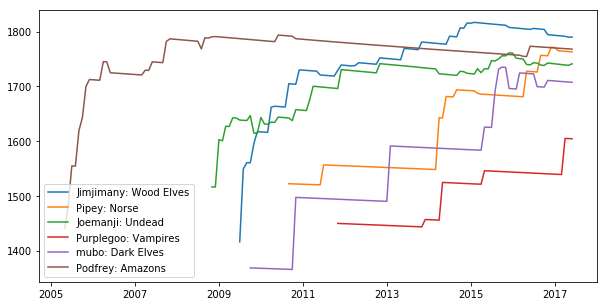

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))

poi = (
    ("Jimjimany", "Wood Elves"),
    ("Pipey", "Norse"),
    ("Joemanji", "Undead"),
    ("Purplegoo", "Vampires"), 
    ("mubo", "Dark Elves"),
    ("Podfrey", "Amazons"))

for coach, race in poi:
    
    ranking_ = ranking_data[coach].hist_mu[race] - (2 * ranking_data[coach].hist_phi[race])
    
    ax.plot(ranking_, label="{0}: {1}".format(coach, race))
ax.legend(loc=3)

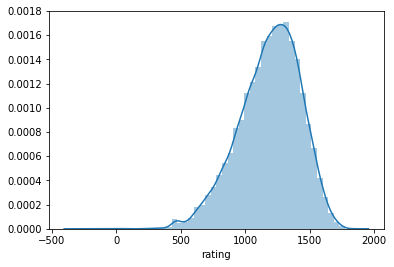

In [35]:
sns.distplot(df_current_ratings)

In [36]:
df_current_ratings.reset_index().iloc[0]

coach     Atropabelladonna
race         Chaos Dwarves
rating             1859.52
Name: 0, dtype: object

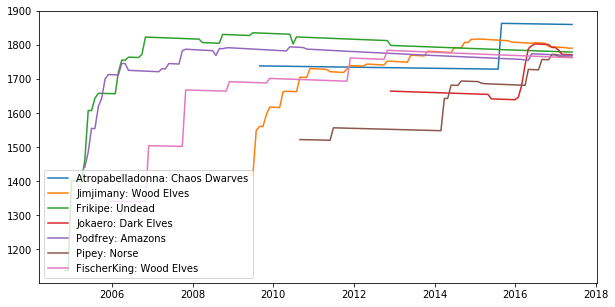

In [37]:
fig, ax = plt.subplots(figsize=(10, 5))

for i in range(7):
    p = df_current_ratings.reset_index().iloc[i]
    coach, race = p.coach, p.race
    ranking_ = ranking_data[coach].hist_mu[race] - (2 * ranking_data[coach].hist_phi[race])
    
    ax.plot(ranking_, label="{0}: {1}".format(coach, race))

ax.legend(loc=3)

In [38]:
x = df_current_ratings.reset_index()

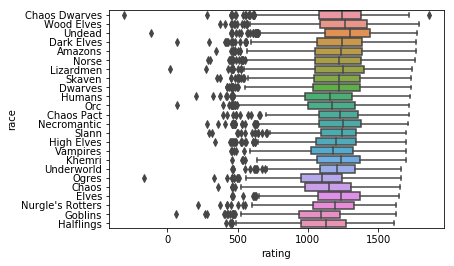

In [39]:
sns.boxplot(y="race", x="rating", data=x)